In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.)

20.0

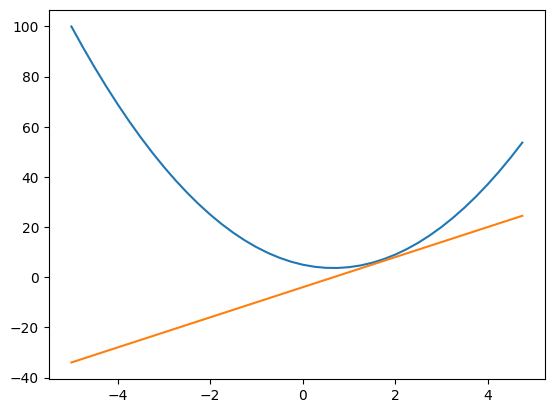

In [11]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
yd = fd(xs)
plt.plot(xs, ys)
plt.plot(xs, yd)

In [5]:
def fd(x):
    return 6*x - 4

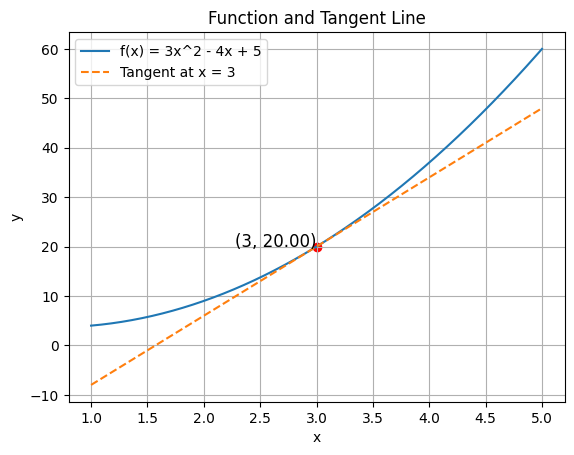

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 3*x**2 - 4*x + 5

def f_prime(x):
    return 6*x - 4  


def draw_tangent(x0):

    slope = f_prime(x0)
    
    y0 = f(x0)
    
    def tangent_line(x):
        return slope * (x - x0) + y0

    x_vals = np.linspace(x0 - 2, x0 + 2, 400)

    y_vals = f(x_vals)
    tangent_vals = tangent_line(x_vals)

    plt.plot(x_vals, y_vals, label="f(x) = 3x^2 - 4x + 5")
    
    plt.plot(x_vals, tangent_vals, '--', label=f"Tangent at x = {x0}")
    
    plt.scatter(x0, y0, color='red')
    plt.text(x0, y0, f"({x0}, {y0:.2f})", fontsize=12, ha='right')
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Function and Tangent Line")
    plt.legend()

    plt.grid(True)
    plt.show()

draw_tangent(3)


In [14]:
a = 2.0
b = -3.
c = 10.
d = a*b + c
d

4.0

In [25]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

In [201]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


    
# a = Value(2.0, label='a')
# b = Value(-3., label='b')
# c = Value(10., label='c'); c.grad = -2.
# e = a*b; e.label='e'; e.grad = -2.
# d = e+c; d.label='d'; d.grad = -2.
# f = Value(-2., label='f'); f.grad=4.
# L = d * f; L.label='L'; L.grad = 1.

# b.grad = e.grad * a.data
# a.grad = e.grad * b.data

L


Value(data=-8.0)

HOW TO CALCULATE GRADIENTS OF RESPECTED NODES:
dL / dL = 1.

L = d * f

dL/dd = f 
dL / df = d

How to get dL / dc ?? 
We need to apply chain rule for calculus
Its very simple we just need to multiple dL/dd and dd/dc so we can get dL/dc

SO:

dL / dc = (dL / dd) * (dd / dc)

dd / dc = 1.0

dL / dc = -2. * 1. = -2.

Now lets calculate dL / da:

dL / da = (dL / de) * (de / da)

dL / de = -2
de / da = b = -3

dL / da = 6

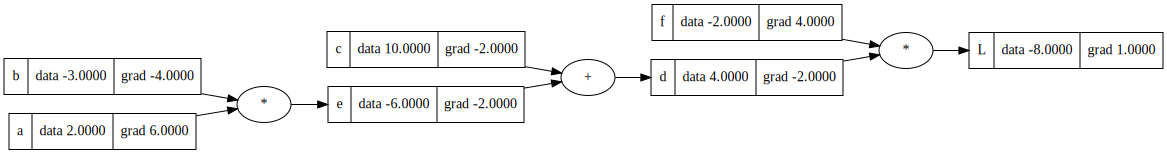

In [30]:
draw_dot(L)

Now imagine that our L is error function that we want to minimize to achive the best results, thanks to calculated gradients we are able to that by moving in the direction of the calculated gradiant.

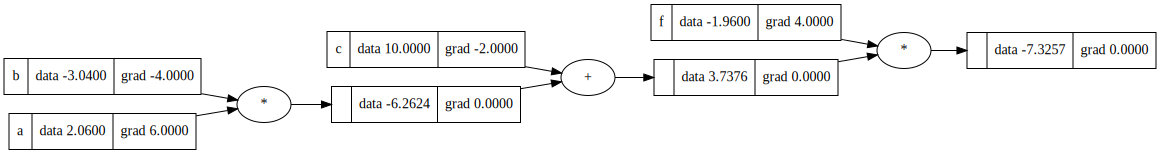

In [31]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
f.data += 0.01*f.grad

e = a*b
d = e+c
L = d * f

draw_dot(L)

Succes! we get lower value of L 

Using that power lets build neuron

In [67]:
x1 = Value(2.0, label='x1')
x2 = Value(0., label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1., label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
neuron = x1w1x2w2 + b; neuron.label='neuron'

output = neuron.tanh(); output.label='output'


In [65]:
def Tanh_grad(x):
    return 1.-x**2

Tanh_grad(output.data)

np.float64(0.4999999999999999)

In [63]:
output.grad = 1.
neuron.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5

x2.grad = 0.5
w2.grad = 0.

x1.grad = -1.5
w1.grad = 1.


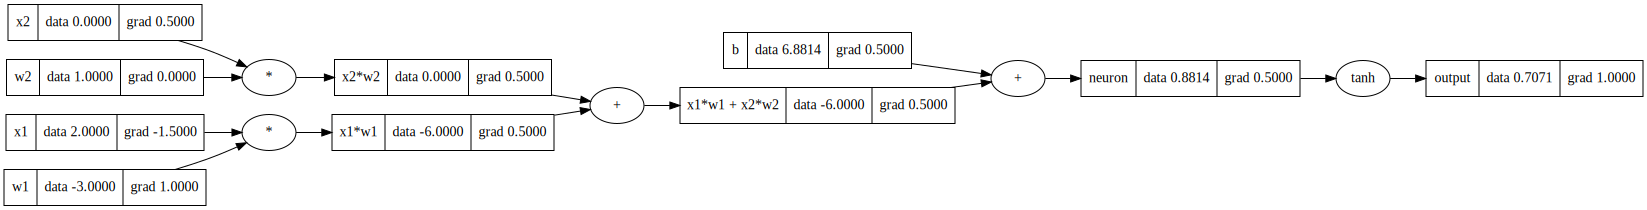

In [64]:
draw_dot(output)

In [104]:
x1 = Value(2.0, label='x1')
x2 = Value(0., label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1., label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
neuron = x1w1x2w2 + b; neuron.label='neuron'

output = neuron.tanh(); output.label='output'

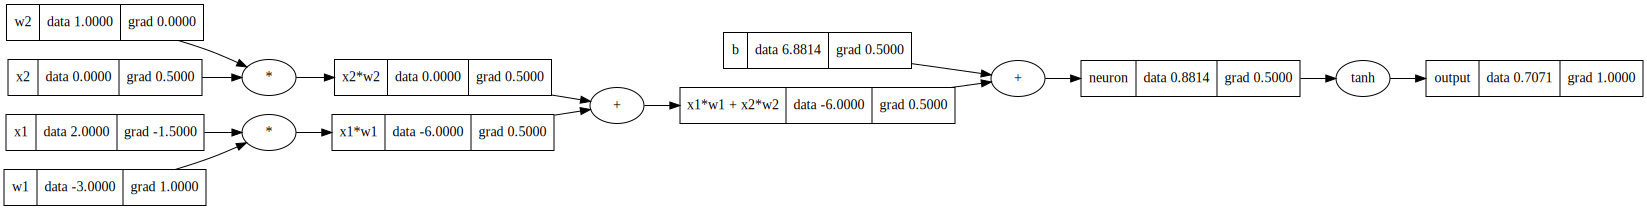

In [105]:
output.backward()
draw_dot(output)

Lets do the same in pytorch

In [107]:
import torch

In [112]:
x1 = torch.Tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True

neuron = x1*w1 + x2*w2 + b
o = torch.tanh(neuron)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Lets wrap everything we did into single Neuron and then Layer of them 

In [202]:
from typing import Any


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(np.random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

        

x = [2.0, 3.0]
n = Neuron(2)

print(n(x))

n = Layer(2, 3)
print(n(x))

x = [2.0, 3.0, -1.]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9876980082136846)
[Value(data=0.3371171192055423), Value(data=0.9911105839740475), Value(data=-0.9399404505776491)]


Value(data=0.3804813124818921)

In [203]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.3804813124818921),
 Value(data=-0.9003204006673324),
 Value(data=0.2885342952584399),
 Value(data=-0.5948035226227554)]

In [204]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.597458332534394)

In [ ]:
loss.backward()

In [206]:
for k in range(10):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad
  
  print(k, loss.data)

0 0.24123729793679932
1 0.21090829708953102
2 0.18693691074318278
3 0.1675687463494853
4 0.15162886039168408
5 0.13830402271328127
6 0.12701521455605289
7 0.11733996636633427
8 0.1089633892793351
9 0.10164634521080168


In [208]:
ypred

[Value(data=0.8837746996453087),
 Value(data=-0.939824876353604),
 Value(data=-0.7789133079913002),
 Value(data=0.8112206211498333)]